### OkCupid DataSet
### Meeting 5, 19- 02- 2020


### Recap last meeting's decisions:
<ol>
  <p>Meeting 4, 28- 01- 2020</p>
    <li> Approach 1: </li>
    <ul>
    <li>Merge classs 1, 3 and 5</li>
    <li>Under sample class 6 </li>
    <li> Merge classes 6, 7, 8</li>
     </ul>    
    <li> Approach 2:</li>
    <ul>
    <li>Merge classs 1, 3 and 5 as class 1</li>    
    <li> Merge classes 6, 7, 8 as class 8</li>
    <li>Under sample class 8 </li>
    </ul>    
    <li> collect metadata: </li>
     <ul>
     <li> Number of misspelled </li>
     <li> Number of unique words </li>
     <li> Avg no wordlength </li>
     </ul>   
    
    

</ol>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.metrics import classification_report

In [2]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm



def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:    
        print('Confusion matrix, without normalization')
         
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0])
                                  , range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [3]:
# Read dataset to dataframe
df = pd.read_csv('../../data/processed/preprocessed_cupid.csv', usecols=['age', 'sex','#anwps', 'clean_text', 'isced', 'isced2'])
df = df.dropna(subset=['clean_text', 'isced'])


## Approach1: 
    - Merge class 1, 3, 5 as class 1
    - Merge class 6, 7, 8 as class 8
    - undersample class 8

In [4]:
df1 = df
print("unique class values in the original dataset:", df1['isced'].unique())
print("classes count table: ", pd.crosstab(index=df1['isced'], columns='count'))


unique class values in the original dataset: [3. 7. 6. 8. 5. 1.]
classes count table:  col_0  count
isced       
1.0      177
3.0     9353
5.0     1450
6.0    25849
7.0    10314
8.0     2781


1,3->0
7,8 ->1
............
1,3->0
5,6->1
7,8->2

In [5]:
# Merge class 1.0, 3.0 and 5.0
df1['isced'].mask(df1['isced'].isin([3.0, 5.0]) , 1.0, inplace=True)
# Merge class 6.0, 7.0 and 8.0
df1['isced'].mask(df1['isced'].isin([6.0, 7.0]) , 8.0, inplace=True)

In [6]:
print('unique class values after merging:', df1['isced'].unique())
print("count table after merging:", pd.crosstab(index=df1['isced'], columns='count'))

unique class values after merging: [1. 8.]
count table after merging: col_0  count
isced       
1.0    10980
8.0    38944


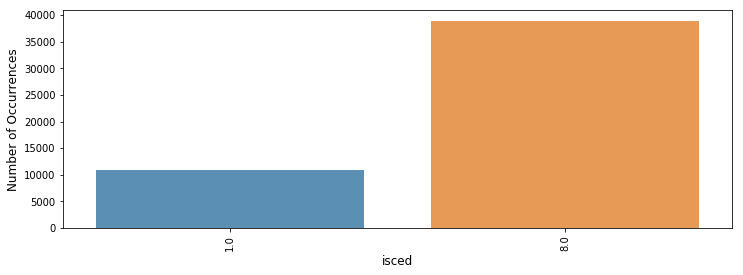

In [7]:
# classes distribution
cnt_isced = df1['isced'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_isced.index, cnt_isced.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('isced', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [8]:
df1 = df1.dropna(subset=['clean_text', 'isced'])
corpus = df1['clean_text']
target = df1["isced"]

# vectorization
X_train, X_val, y_train, y_val = train_test_split(corpus, target, train_size=0.75,
                                                          test_size=0.25, random_state = 0)
vectorizer = CountVectorizer(binary=False, ngram_range=(1, 2), lowercase=True)
vectors_train = vectorizer.fit_transform(X_train)
vectors_val = vectorizer.transform(X_val)
X_train = vectors_train
X_val = vectors_val

In [147]:
# count train items
from collections import Counter
print(sorted(Counter(y_val).items()))
print(sorted(Counter(y_train).items()))

[(1.0, 2715), (8.0, 9766)]
[(1.0, 8265), (8.0, 29178)]


[(1.0, 8265), (8.0, 8265)]


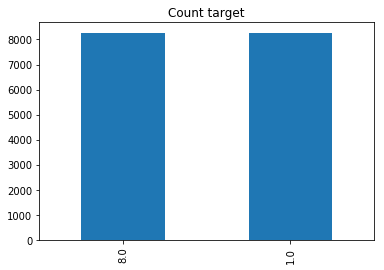

In [92]:
# undersampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
y_resampled.value_counts().plot(kind='bar', title= 'Count target')


print(sorted(Counter(y_resampled).items()))


train score: 0.9667761664396549
Final Accuracy for NB: 0.7836711801938947
Confusion matrix, without normalization
[[  24 2691]
 [   9 9757]]
              precision    recall  f1-score   support

         1.0       0.73      0.01      0.02      2715
         8.0       0.78      1.00      0.88      9766

    accuracy                           0.78     12481
   macro avg       0.76      0.50      0.45     12481
weighted avg       0.77      0.78      0.69     12481



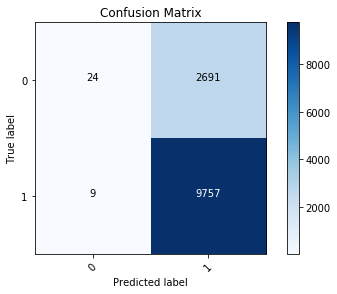

In [148]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(MultinomialNB())
# model.fit(X_resampled, y_resampled)
model.fit(X_train, y_train)
# train_score = model.score(X_resampled, y_resampled)
train_score = model.score(X_train, y_train)

print('train score:', train_score)
gnb_predictions = model.predict(X_val)
print("Final Accuracy for NB: %s"% accuracy_score(y_val, gnb_predictions))
cm = confusion_matrix(y_val,gnb_predictions)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1], normalize=False,
                      title='Confusion Matrix')
print(classification_report(y_val, gnb_predictions))

train score: 0.9667761664396549
Final Accuracy for LogisticRegression: 0.8309430334107843
Confusion matrix, without normalization
[[1518 1197]
 [ 913 8853]]
              precision    recall  f1-score   support

         1.0       0.62      0.56      0.59      2715
         8.0       0.88      0.91      0.89      9766

    accuracy                           0.83     12481
   macro avg       0.75      0.73      0.74     12481
weighted avg       0.83      0.83      0.83     12481



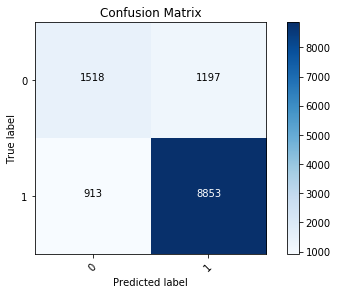

In [149]:
from sklearn.linear_model import LogisticRegression

# clf = LogisticRegression(random_state=0,max_iter=1000, solver='lbfgs', penalty='l2').fit(X_resampled, y_resampled)
clf = LogisticRegression(random_state=0,max_iter=1000, solver='lbfgs', penalty='l2', class_weight='balanced').fit(X_train, y_train)
# train_score = model.score(X_resampled, y_resampled)
train_score = clf.score(X_train, y_train)

print('train score:', train_score)

logistic_predictions = clf.predict(X_val)
print("Final Accuracy for LogisticRegression: %s"% accuracy_score(y_val, logistic_predictions))

cm = confusion_matrix(y_val,logistic_predictions)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1], normalize=False,
                      title='Confusion Matrix')
print(classification_report(y_val, logistic_predictions))

In [151]:
# Necessary imports: Try cross validation
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

df1 = df1.dropna(subset=['clean_text', 'isced'])
corpus = df1['clean_text']
target = df1["isced"]


vectorizer = CountVectorizer(binary=False, ngram_range=(1, 2), lowercase=True)
vectors_corpus = vectorizer.fit_transform(corpus)


clf = LogisticRegression(random_state=0,max_iter=1000, solver='lbfgs', penalty='l2', class_weight='balanced').fit(X_train, y_train)
scores = cross_val_score(clf, vectors_corpus, target, cv=5)
print(scores)
print(scores.mean())


y_pred = cross_val_predict(clf, vectors_corpus, target, cv=5)
conf_mat = confusion_matrix(target, y_pred)
print(conf_mat)

[0.83274912 0.83575363 0.83685528 0.82513771 0.83343349]
0.8327858474410335
[[ 6130  4850]
 [ 3498 35446]]


array([0.83274912, 0.83575363, 0.83685528, 0.82513771, 0.83343349])

0.8327858474410335


array([[ 6130,  4850],
       [ 3498, 35446]], dtype=int64)

In [152]:
print(classification_report(target, y_pred))

              precision    recall  f1-score   support

         1.0       0.64      0.56      0.59     10980
         8.0       0.88      0.91      0.89     38944

    accuracy                           0.83     49924
   macro avg       0.76      0.73      0.74     49924
weighted avg       0.83      0.83      0.83     49924

